<a href="https://colab.research.google.com/github/osimon8/GeoguessrGuessr/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 %matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt
#import sklearn.ensemble.RandomForestClassifier as RandomForestClassifier
import pandas as pd
import os 
import sys
import geopandas
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision

np.random.seed(0)
torch.manual_seed(0)

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 20.3MB/s 
     |████████████████████████████████| 15.3MB 211kB/s 
     |████████████████████████████████| 6.5MB 46.6MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_data_directory = '/content/drive/MyDrive/CIS 522/50States500'
test_data_directory = 'test_data'


dataset = datasets.ImageFolder(train_data_directory, transforms.Compose([transforms.ToTensor()]))
#train_dataset, val_dataset = torch.utils.data.random_split(dataset, )
train_dataset = dataset

validation_dataset = []

batch_size = 4
batch_size_big = 100

data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
data_loader_big = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size_big)
data_loader_shuffled = torch.utils.data.DataLoader(train_dataset, batch_size = 100, shuffle=True)
validation_loader = []


In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 25000
    Root location: /content/drive/MyDrive/CIS 522/50States500
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
def get_state_data_loader(state, batch_size=100):
    tot = len(train_dataset)
    c = train_dataset.class_to_idx [state]
    weights = [1e-4 if i // 500 == c else 0 for i in range(tot)]
    sampler = torch.utils.data.WeightedRandomSampler(weights, batch_size)
    return  torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, sampler=sampler)
    
    

## Data Visualization

### Sample set of images
Here we see the four images for a random coordinate sampled from the dataset. The images appear in the order of camera rotation 0, 90, 180, and 270 degrees.

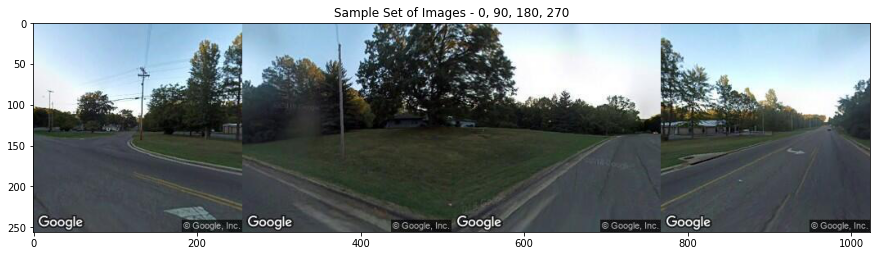

In [ ]:
example_batch = next(iter(data_loader))[0]
stacked = example_batch[0]
for i in range(1, 4):
    stacked = torch.cat((stacked,example_batch[i]), 2)
    
plt.figure(figsize=(15,10))
plt.title("Sample Set of Images - 0, 90, 180, 270")
plt.imshow(stacked.permute(1, 2, 0))

### Sample image for each state

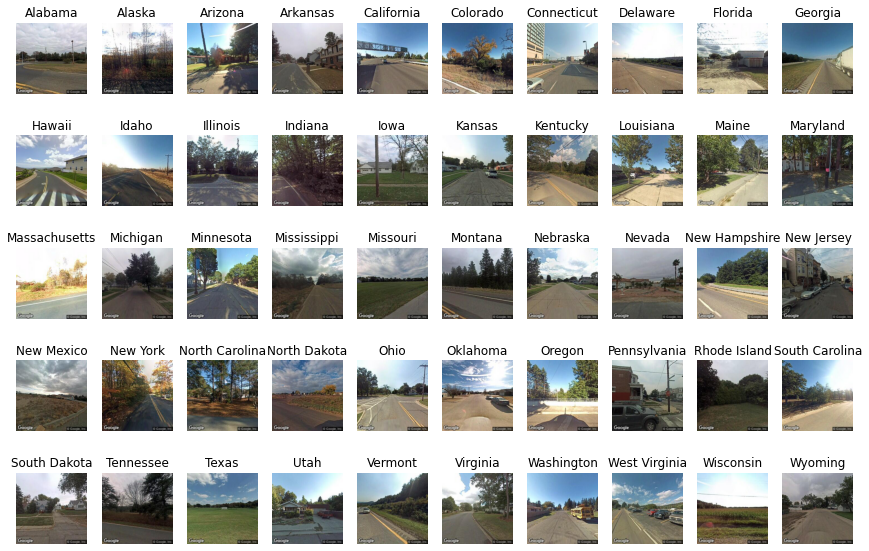

In [ ]:
sample_50 = {}
for data, label in data_loader_shuffled:
    for d, l in zip(data, label):
        if l.item() in sample_50.keys():
            continue
        sample_50[l.item()] = d
    if (len(sample_50) == 50):
        break

fig, axs = plt.subplots(5, 10, figsize=(15,10))
for label, im in sorted(sample_50.items()):    
    ax = axs.flat[label] 
    ax.set_title(train_dataset.classes[label])
    ax.imshow(im.permute(1, 2, 0))
    ax.axis('off')

### Average image and histogram by state 
In this section, we sample some random images for a given state, then average all of those images together and plot a histogram. We can see that for all states we tend towards an image with a gray bottom half and a bluish top half, indicating that our average image looks at the road with the sky above it. Sampling a smaller number of images is a little bit more informative; we can start to make out that more rural states tend to have more trees visible and urban states have more gray color overall.

In [ ]:
def collect_state_data(desired_states, num = 10):
    results = {state: [] for state in desired_states }

    for state in desired_states:
        loader = get_state_data_loader(state, batch_size = num)
        for data, _ in loader:
            results[state].extend(data)
            
    return results

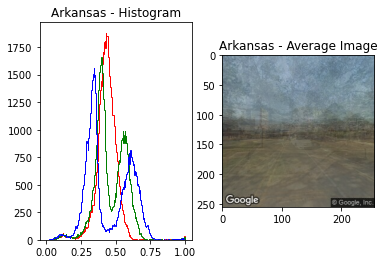

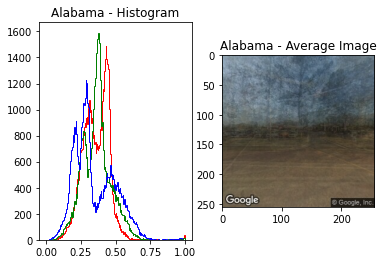

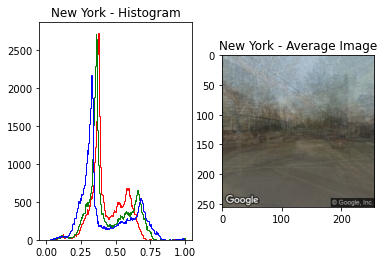

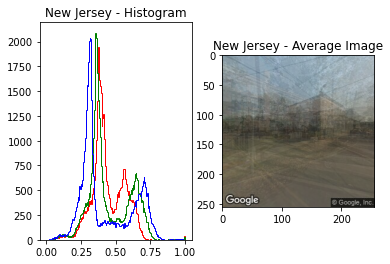

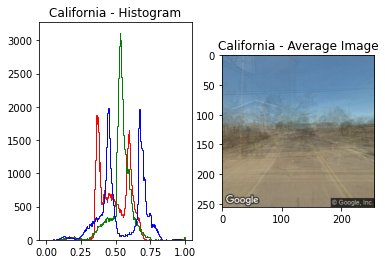

In [ ]:
desired_states = ['Arkansas', 'Alabama', 'New York', 'New Jersey', 'California']
num_images = 10

state_data = collect_state_data(desired_states, num=num_images)
means = {}
colors = ['red', 'green', 'blue']

for state in desired_states:
    tens = torch.stack(state_data[state])
    mean = torch.mean(tens, dim=0).permute(1, 2, 0)
    fig = plt.figure()
    plt.axis('off')

    fig.add_subplot(121)
    plt.title('{} - Histogram'.format(state))
    for i in range(3):
        plt.hist(mean.numpy()[:, :, i].ravel(), bins=256, range=(0.0, 1.0), histtype='step', color=colors[i])
    
    fig.add_subplot(122)
    plt.title('{} - Average Image'.format(state))
    plt.imshow(mean)
    
    plt.show()

In [ ]:
states = geopandas.read_file('map_data/States_shapefile.shp')
states = states.to_crs("EPSG:3395")
states_contig = states[states['State_Name'] != 'HAWAII']
states_contig = states_contig[states_contig['State_Name'] != 'ALASKA']

# us_boundary_map = states_contig.boundary.plot(figsize=(18, 12), color='Black', linewidth=1)
# us_map = states_contig.plot(ax=us_boundary_map, linewidth=4)
# us_map.axis('off')

DriverError: ignored

In [ ]:
ny = states[states['State_Name'] == 'NEW YORK']
ny_boundary = ny.boundary.plot(figsize=(9, 6), color='Black', linewidth=1)
us_map = ny.plot(ax=ny_boundary, linewidth=4)
us_map.axis('off')
print(dataset)

In [ ]:
dataframe = pd.DataFrame()

ctr = 0

# for data, label in data_loader:
#     num = data.numpy()
#     dataframe.append(num)
#     ctr += 1
#     if (ctr > 1000):
#         break
    #dataframe.insert()


In [ ]:
#print(train_dataset.imgs[:1000])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier()
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=1e-07,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
from sklearn.metrics import accuracy_score


data_loader_all = torch.utils.data.DataLoader(train_dataset, batch_size = 1000, shuffle=True)
(X,y) = next(iter(data_loader_all))



# for (inputX, inputY) in data_loader_all:
#   X[i:i+10000] =inputX
#   y[i:i+10000] = inputY
#   i = i + 25000
#   break 
# print(X)



In [ ]:
print(X.shape)
X = X.reshape(1000, -1)


torch.Size([1000, 3, 256, 256])


In [ ]:
randomForest.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import accuracy_score
X_test, y_test = next(iter(data_loader_big))


ValueError: ignored

In [ ]:
X_test = X_test.reshape(100, -1)
preds = randomForest.predict(X_test)
print("Accuracy:", accuracy_score(y_test,preds))

Accuracy: 0.05


In [ ]:

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 64, 3, 1)
        self.conv5 = nn.Conv2d(64, 32, 3, 1)
        self.fc1 = nn.Linear(288, 128)
        self.fc2 = nn.Linear(128, 50)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        x = self.conv5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 3)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
       
        return x

In [ ]:
def train(model, device, train_loader, validation_loader, epochs):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                              lr=0.01, momentum=0.9)
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)

                # add micro for coding training loop
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        train_loss.append(running_loss/len(train_loader))
        train_acc.append(correct/total)
                
        # evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
    
    return train_loss, train_acc, validation_loss, validation_acc 



In [ ]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

In [ ]:
from tqdm.notebook import tqdm, trange


In [ ]:
device

device(type='cuda')

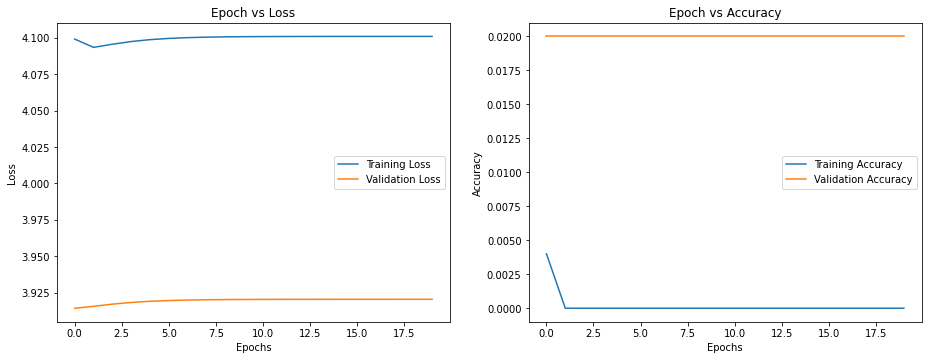

In [ ]:
net = Net1().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, data_loader_big, data_loader, 20)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)
